# Importing Libraries

In [3]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torch.optim as optim

In [9]:
#Hyper parameters

bsize = 4
loss_rate = 0.001
momentum = 0.9
output_path = "./classifier.pth"
train_iterations = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
#Utility Functions

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



In [6]:
tranform = transforms.Compose([transforms.Resize((32,32)) ,transforms.ToTensor() , transforms.Normalize((0.5 ,0.5,0.5) , (0.5,0.5,0.5) )])

In [15]:
#Loading datasets

training_set = torchvision.datasets.CIFAR10('./data/train' , train=True , transform=tranform , download=True)
validation_set = torchvision.datasets.CIFAR10('./data/test' , train=False , transform=tranform , download=True)

#Create Data Loaders

train_dataloader = torch.utils.data.DataLoader(training_set , batch_size = bsize , shuffle=True)
test_dataloader = torch.utils.data.DataLoader(validation_set , batch_size = bsize , shuffle=False)

print('training set: ',len(training_set))
print('validation set: ' ,len(validation_set))


classes = ['airplane' ,'automobile','bird' ,'cat' ,'deer' ,'dog' ,'frog' ,'horse' ,'ship','truck']

Files already downloaded and verified
Files already downloaded and verified
training set:  50000
validation set:  10000


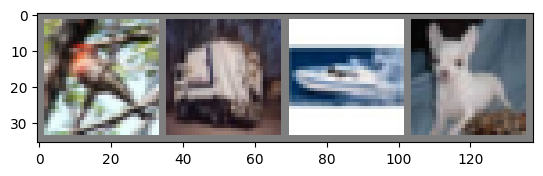

bird  truck ship  dog  


In [96]:

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(bsize)))

In [7]:
#Model

class ImageClassifier(nn.Module):

    def __init__(self):
        super(ImageClassifier , self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3 , out_channels=6 , kernel_size=5) #3 input channel R G B , output to 6 , with kernel size of 5*5
        self.pool = nn.MaxPool2d(kernel_size=2 , stride=2) # Find maximum value in 2*2 square on output tensor
        self.conv2 = nn.Conv2d(in_channels=6 , out_channels=16 , kernel_size=5) # antoher convolution layer 

        self.fc1 = nn.Linear(in_features=16*5*5 , out_features= 128) # in feature is 16 * 5 *5  where 16 is output of conv2 with a feature map of 5 * 5 
        self.fc2 = nn.Linear(in_features=128 , out_features= 84)
        self.fc3 = nn.Linear(in_features=84 , out_features= 10)
    
    def forward(self ,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1 , 16*5*5) #flatten image to 1d into proper format alternative torch.flatten(x ,1) , used x.view for clarity purpose

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x
        

In [29]:
classifier = ImageClassifier().to(device)

In [34]:
# defining loss function

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=classifier.parameters() , lr = loss_rate , momentum= momentum) #Scotastic Gradient Descent 

In [36]:
# training loop
for epoch in range(train_iterations):

    running_loss = 0.0

    for i , data in enumerate(train_dataloader):

        #Parse the data
        image , labels = data

        image = image.to(device)
        labels = labels.to(device)


        optimizer.zero_grad() #reset gradient values

        outputs = classifier(image)
        
        #calculate loss
        loss = criterion(outputs , labels)
        loss.backward()

        optimizer.step()

        #print stats
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('\r Batch , Iterations [',epoch +1 ,', ',i +1,'] running loss = ',running_loss * (1/100),'%')
            running_loss = 0.0

torch.save(classifier.state_dict() , output_path) #save the model
print('Training finished')

 [ 1 ,  2000 ] running loss =  3977.521087884903
 [ 1 ,  4000 ] running loss =  3877.1444787979126
 [ 1 ,  6000 ] running loss =  3755.9655770361423
 [ 1 ,  8000 ] running loss =  3667.9473499655724
 [ 1 ,  10000 ] running loss =  3592.00642991066
 [ 1 ,  12000 ] running loss =  3595.174206510186
 [ 2 ,  2000 ] running loss =  3393.5817890018225
 [ 2 ,  4000 ] running loss =  3329.739954471588
 [ 2 ,  6000 ] running loss =  3256.5493239164352
 [ 2 ,  8000 ] running loss =  3221.9444797188044
 [ 2 ,  10000 ] running loss =  3139.7033868432045
 [ 2 ,  12000 ] running loss =  3139.946608789265
Training finished


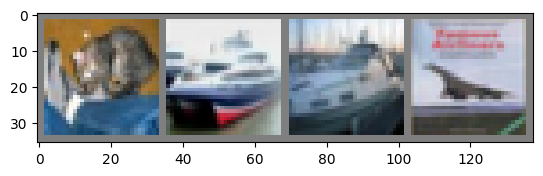

GroundTruth:  cat   ship  ship  airplane


In [16]:
#testing

dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(bsize)))

In [17]:
net = ImageClassifier()
net.load_state_dict(torch.load(output_path))

<All keys matched successfully>

In [18]:
outputs = net(images)

_,predicted = torch.max(outputs ,1)


print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  airplane airplane


In [19]:
correct = 0
total = 0
# don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


In [20]:
# dicts to count the predications for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 66.7 %
Accuracy for class: automobile is 75.3 %
Accuracy for class: bird  is 54.8 %
Accuracy for class: cat   is 48.5 %
Accuracy for class: deer  is 53.9 %
Accuracy for class: dog   is 37.2 %
Accuracy for class: frog  is 73.2 %
Accuracy for class: horse is 65.3 %
Accuracy for class: ship  is 79.1 %
Accuracy for class: truck is 61.6 %
